In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import warnings
import imblearn

from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pydot

In [2]:
train_data= pd.read_csv('data_train.csv')
train_data.dropna(axis = 0, how ='any',inplace=True) 


train_data['Num_words_text'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
max_train_sentence_length  = train_data['Num_words_text'].max()

test_data= pd.read_csv('data_test.csv')
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
1    754
0    754
Name: sentiment, dtype: int64
1508
-------Test data--------
1    443
0    222
Name: sentiment, dtype: int64
665
-------------------------
Train Max Sentence Length :306
Test Max Sentence Length :242


In [3]:
corpus = train_data['review'].values.astype('U')
# test_data['review'].values.astype('U')

In [9]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(corpus.tolist())

print(str(tokenizer.texts_to_sequences(['nice spot hang friend see also sunset amazing beside many option restaurant choose along'])))

[[12, 97, 430, 593, 21, 1, 4, 260, 1354, 29, 321, 28, 348, 26]]


In [5]:
vec = TfidfVectorizer(stop_words='english')
resp = vec.fit_transform(corpus)
print(resp)

  (0, 3253)	0.20803654478662795
  (0, 4896)	0.17334819711302293
  (0, 2588)	0.10034841201300373
  (0, 1698)	0.16365390345082786
  (0, 3432)	0.14368324439453467
  (0, 1794)	0.18806588573033475
  (0, 3612)	0.15641314001142267
  (0, 4468)	0.15197181678820898
  (0, 1559)	0.15197181678820898
  (0, 4469)	0.10909797937394598
  (0, 2723)	0.19331885616931613
  (0, 2521)	0.13488471938241767
  (0, 2677)	0.20803654478662795
  (0, 1204)	0.18362456250712106
  (0, 3634)	0.19974797239295364
  (0, 2970)	0.16365390345082786
  (0, 464)	0.10818324950516199
  (0, 717)	0.14075072509285802
  (0, 3439)	0.17977731333666044
  (0, 3657)	0.3335518363132237
  (0, 3190)	0.14473105334880385
  (0, 2569)	0.09900809728967562
  (0, 4824)	0.11203049867562262
  (0, 4803)	0.14808049505634005
  (0, 2615)	0.12476039429251064
  :	:
  (1505, 4469)	0.25142281618658574
  (1506, 1552)	0.39159952806683596
  (1506, 4413)	0.25707502169008045
  (1506, 1045)	0.3100617872703011
  (1506, 4797)	0.5995271357098845
  (1506, 966)	0.30470921

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(corpus.tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

# sm = SMOTE()
# try :
#     x_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# except ValueError:
#     pass


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )

#Normal
# x_train = pad_sequences(x_train, padding='post', maxlen=1210)
# x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
# x_test = pad_sequences(x_test, padding='post', maxlen=390)

#Undersampling
x_train = pad_sequences(x_train, padding='post', maxlen=390)
x_valid = pad_sequences(x_valid, padding='post', maxlen=390)
x_test = pad_sequences(x_test, padding='post', maxlen=390)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:1206
Class distributionCounter({0: 603, 1: 603})
Valid data len:302
Class distributionCounter({1: 151, 0: 151})
[  55  154 4354   88   85  208   31   33  410    2  561    5  410   56
  184   60 4355 4356    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
Text to number
[0 1 1 0 0 0 0 0 0 1]
Number to category
[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [8]:
# count =0
# print('======Train dataset ====')
# for value,label in train_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# count =0
# print('======Validation dataset ====')
# for value,label in valid_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# print('======Test dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break

In [9]:
max_features =20000
embedding_dim =64
sequence_length = 1210

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(64,2, padding='valid', activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

# model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(64, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# model.add(tf.keras.layers.Dropout(0.5))

# model.add(tf.keras.layers.Dense(32, activation='relu',\
#                                 kernel_regularizer=regularizers.l2(0.001),\
#                                 bias_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# custom_early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=1, 
#     min_delta=0.001, 
#     mode='auto'
# )
                               

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 64)          8256      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,292,610
Trainable params: 1,292,610
Non-trainable params: 0
______________________________________________

In [10]:
import graphviz

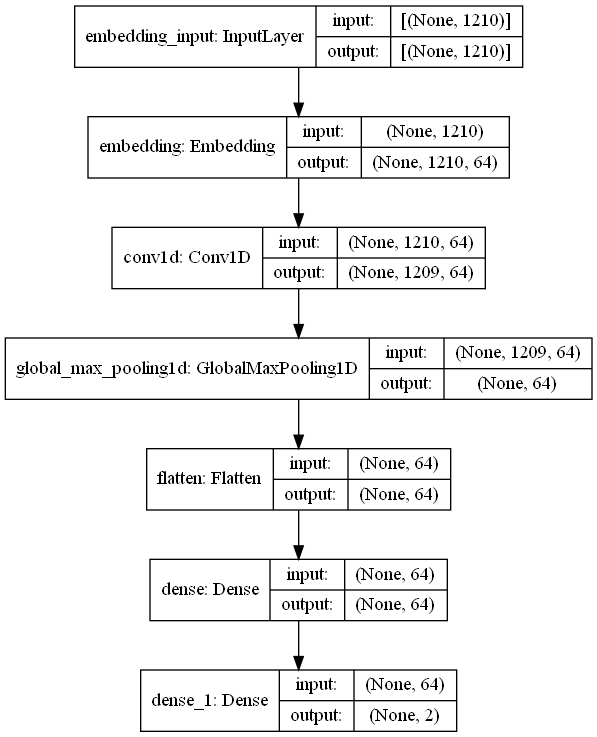

In [11]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [12]:
epochs = 5
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(64),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(64),
                    verbose=2)

# ,
#                     callbacks=[custom_early_stopping]

Epoch 1/5


E:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


19/19 - 3s - loss: 1.1131 - accuracy: 0.5638 - val_loss: 0.9270 - val_accuracy: 0.7947
Epoch 2/5
19/19 - 1s - loss: 0.8176 - accuracy: 0.8449 - val_loss: 0.7472 - val_accuracy: 0.7649
Epoch 3/5
19/19 - 1s - loss: 0.6321 - accuracy: 0.8823 - val_loss: 0.5915 - val_accuracy: 0.8344
Epoch 4/5
19/19 - 1s - loss: 0.4566 - accuracy: 0.8964 - val_loss: 0.4924 - val_accuracy: 0.8311
Epoch 5/5
19/19 - 1s - loss: 0.3243 - accuracy: 0.9362 - val_loss: 0.4566 - val_accuracy: 0.8642


In [13]:
len(history.history['loss'])

5

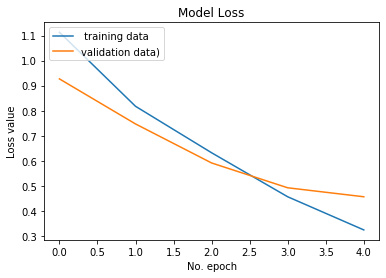

In [14]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Model Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

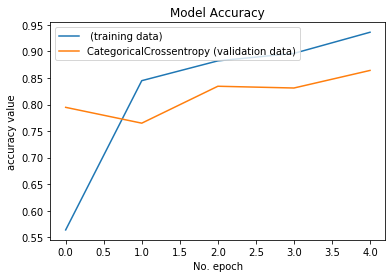

In [15]:
plt.plot(history.history['accuracy'], label=' (training data)')
plt.plot(history.history['val_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('Model Accuracy')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [16]:
import pickle

model.save('UndersampledModel5\\tf_cnnmodel') 

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: UndersampledModel5\tf_cnnmodel\assets


In [8]:
new_model = tf.keras.models.load_model('UndersampledModel5\\tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 64)          8256      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,292,610
Trainable params: 1,292,610
Non-trainable params: 0
______________________________________________

In [305]:
test_data = pd.read_csv('canggu_test.csv', converters={'reviews' : str})
# test_data.drop(["Date", "Content"], axis=1, inplace=True)
# test_data.dropna()
# test_data = test_data.fillna("")
test_data.sample(5)

,Date,Content,review,scores,compound,sentiment
91,Dec-14,"Beach, Surf and Laid back atmosphere. Great fo...",surf lay back atmosphere great food nice peopl...,"{'neg': 0.0, 'neu': 0.413, 'pos': 0.587, 'comp...",0.9652,1
86,Sep-12,Quiet area with some nice restaurants. Black/g...,quiet area nice restaurant blackgrey sand lot ...,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.8519,1
126,Jun-19,If you're looking for a nice and less crowded ...,youre look nice less crowded come good place e...,"{'neg': 0.0, 'neu': 0.529, 'pos': 0.471, 'comp...",0.9226,1
110,Jun-16,Many tourists come here for surfing. Not crowd...,many tourist come surf crowd people good place...,"{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compou...",0.8625,1
21,Aug-19,I have always stayed in Legian this time I dec...,always stay legian time decide try different p...,"{'neg': 0.0, 'neu': 0.55, 'pos': 0.45, 'compou...",0.8689,1


In [306]:
try:
    x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
    # x_test = tokenizer
    x_test = pad_sequences(x_test, padding='post', maxlen=1210)
except AttributeError:
    pass

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [307]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.29783478 0.6333157 ]
 [0.1984351  0.7612611 ]
 [0.12212637 0.8497074 ]
 [0.11567321 0.8531604 ]
 [0.24406475 0.7128715 ]
 [0.2913932  0.66190237]
 [0.3893692  0.56644845]
 [0.22077751 0.73224276]
 [0.16658232 0.7801552 ]
 [0.49058807 0.48069167]
 [0.31860632 0.63480216]
 [0.2628477  0.69042873]
 [0.52065563 0.4445144 ]
 [0.55148554 0.4240864 ]
 [0.20852485 0.7339435 ]
 [0.46142495 0.4992718 ]
 [0.25594133 0.681024  ]
 [0.77289754 0.23213005]
 [0.09813446 0.8675667 ]
 [0.23545662 0.7045293 ]
 [0.33188218 0.61772895]
 [0.25769538 0.69007266]
 [0.31423512 0.6277957 ]
 [0.27226782 0.66750103]
 [0.26125008 0.6769077 ]
 [0.05067635 0.92159545]
 [0.63362217 0.33267504]
 [0.7650213  0.22346711]
 [0.2505203  0.69011307]
 [0.1243867  0.8346541 ]
 [0.6376916  0.33001906]
 [0.7082425  0.2916832 ]
 [0.54913354 0.42897528]
 [0.44936156 0.5092272 ]
 [0.4740508  0.47016066]
 [0.5914686  0.37619132]
 [0.689569   0.28382894]
 [0.10969403 0.8547995 ]
 [0.5245525  

In [308]:
print(len(x))

840


In [309]:
print(len(predict_results))

129


In [310]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'0',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'1',test_data.pred_sentiment)

In [311]:
labels = ['0', '1']
    
print(classification_report(test_data['sentiment'].values.astype(int).astype(str),test_data['pred_sentiment'].values,labels=labels))

              precision    recall  f1-score   support

           0       0.11      0.57      0.19         7
           1       0.97      0.74      0.84       122

    accuracy                           0.73       129
   macro avg       0.54      0.65      0.51       129
weighted avg       0.92      0.73      0.80       129



In [312]:
# df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(test_data['sentiment'], test_data['pred_sentiment'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0   1
Actual           
0           4   3
1          32  90


In [313]:
roc_auc = roc_auc_score(test_data['sentiment'], test_data['pred_sentiment'])

print("ROC AUC Score")
print(roc_auc)

ROC AUC Score
0.6545667447306791


In [314]:
# sentiment = ['negative','positive']
sequence20 = tokenizer.texts_to_sequences(['perfect morning walk amazing sunrise'])


test20 = pad_sequences(sequence20, padding="post")
labels[np.around(new_model.predict(test20)).argmax(axis=1)[0]]

'1'

In [315]:
sequence30 = tokenizer.texts_to_sequences(['dont recommend rubbish everywhere'])


test30 = pad_sequences(sequence30, padding="post")
labels[np.around(new_model.predict(test30)).argmax(axis=1)[0]]

'0'